# **Arabic Optical Character Recognition**

This work aims to build a powerful Arabic OCR system ✨ that uses cutting-edge open-source transformer models 🤖. The system reads and converts Arabic text from:

📄 Scanned pages

✍️ Handwritten manuscripts

🖨️ Printed documents

Using a modern vision-to-text architecture, it achieves accurate transcription even with different fonts, noisy scans, and complex page layouts. 🔤🧠💡

In [1]:
!pip install -U transformers

In [2]:
pip install python-Levenshtein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 90.6 MB/s eta 0:00:00


## Local Inference on GPU
Model page: https://huggingface.co/MohamedRashad/arabic-small-nougat

⚠️ If the generated code snippets do not work, please open an issue on either the [model repo](https://huggingface.co/MohamedRashad/arabic-small-nougat)
			and/or on [huggingface.js](https://github.com/huggingface/huggingface.js/blob/main/packages/tasks/src/model-libraries-snippets.ts) 🙏

In [3]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("image-to-text", model="MohamedRashad/arabic-small-nougat")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/models/auto/modeling_auto.py:2284: FutureWarning: The class `AutoModelForVision2Seq` is deprecated and will be removed in v5.0. Please use `AutoModelForImageTextToText` instead.
  warnings.warn(


model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cuda:0


In [4]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForVision2Seq

tokenizer = AutoTokenizer.from_pretrained("MohamedRashad/arabic-small-nougat")
model = AutoModelForVision2Seq.from_pretrained("MohamedRashad/arabic-small-nougat")

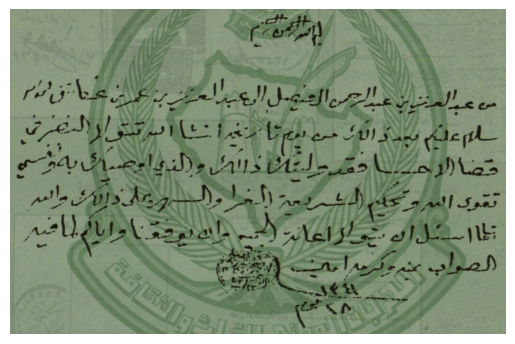

ValueError: Unable to infer channel dimension format

In [8]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
from transformers import NougatProcessor, VisionEncoderDecoderModel

# Load the model and processor
processor = NougatProcessor.from_pretrained("MohamedRashad/arabic-small-nougat")
model = VisionEncoderDecoderModel.from_pretrained("MohamedRashad/arabic-small-nougat")
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

context_length = 2048

def predict(img_path):
    # prepare PDF image for the model
    image = Image.open(img_path)
    pixel_values = processor(image, return_tensors="pt").pixel_values

    # generate transcription
    outputs = model.generate(
        pixel_values.to(device),
        min_length=1,
        max_new_tokens=context_length,
        bad_words_ids=[[processor.tokenizer.unk_token_id]],
    )

    page_sequence = processor.batch_decode(outputs, skip_special_tokens=True)[0]
    page_sequence = processor.post_process_generation(page_sequence, fix_markdown=False)
    return page_sequence

path = "H_W_Text_09.jpg"
img = Image.open(path)
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()
print(predict(path))


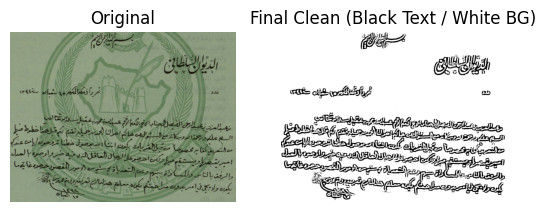

In [27]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread("H_W_Text_13.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = cv2.fastNlMeansDenoising(gray, None, 30, 7, 21)

background = cv2.medianBlur(gray, 35)
diff = cv2.absdiff(gray, background)
norm = cv2.normalize(diff, None, 0, 255, cv2.NORM_MINMAX)

bw = cv2.adaptiveThreshold(
    norm, 255,
    cv2.ADAPTIVE_THRESH_MEAN_C,
    cv2.THRESH_BINARY,
    21, 15
)

# Morphological cleaning
kernel = np.ones((2, 2), np.uint8)
bw_clean = cv2.morphologyEx(bw, cv2.MORPH_OPEN, kernel)

# ✅ Invert to get black text on white background
#bw_clean = cv2.bitwise_not(bw_clean)

cv2.imwrite("text_black_white.png", bw_clean)

plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Final Clean (Black Text / White BG)")
plt.imshow(bw_clean, cmap="gray")
plt.axis("off")
plt.show()


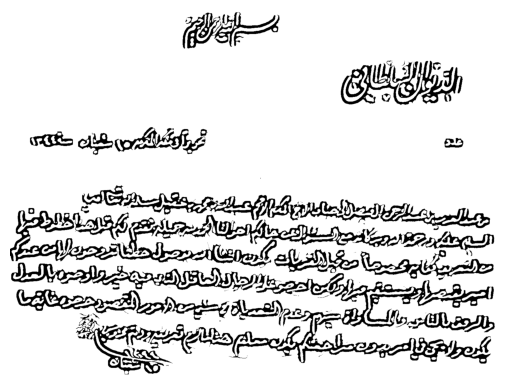

In [29]:
plt.imshow(bw_clean, cmap="gray")
plt.axis("off")
plt.show()

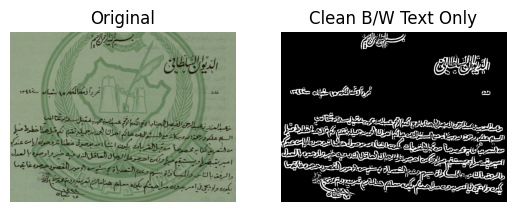

In [25]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# --- Step 1: Read image ---
img = cv2.imread("H_W_Text_13.jpg")

# --- Step 2: Convert to grayscale ---
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# --- Step 3: Denoise slightly (helps with colored backgrounds) ---
gray = cv2.fastNlMeansDenoising(gray, None, 30, 7, 21)

# --- Step 4: Estimate background using large blur ---
background = cv2.medianBlur(gray, 35)

# --- Step 5: Subtract background and normalize contrast ---
diff = cv2.absdiff(gray, background)
norm = cv2.normalize(diff, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

# --- Step 6: Apply adaptive threshold ---
bw = cv2.adaptiveThreshold(
    norm, 255,
    cv2.ADAPTIVE_THRESH_MEAN_C,
    cv2.THRESH_BINARY,
    21, 15
)

# --- Step 7: (Optional) Invert if needed ---
bw = cv2.bitwise_not(bw)

# --- Step 8: Remove tiny background dots using morphology ---
kernel = np.ones((2, 2), np.uint8)
bw_clean = cv2.morphologyEx(bw, cv2.MORPH_OPEN, kernel)

# --- Step 9: Save & show ---
#cv2.imwrite("clean_text_only.png", bw_clean)

plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Clean B/W Text Only")
plt.imshow(bw_clean, cmap="gray")
plt.axis("off")
plt.show()


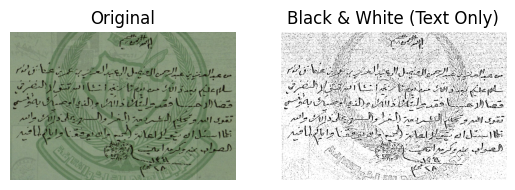

In [30]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Load the scanned document
img = cv2.imread("H_W_Text_09.jpg")

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Remove shadows and uneven lighting
background = cv2.medianBlur(gray, 25)
diff = 255 - cv2.absdiff(gray, background)
norm = cv2.normalize(diff, None, 0, 255, cv2.NORM_MINMAX)

# Apply adaptive threshold to get black text on white
bw = cv2.adaptiveThreshold(
    norm, 255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY,
    15, 10
)
bw = cv2.morphologyEx(bw, cv2.MORPH_OPEN, np.ones((2,2), np.uint8))

# Optional: invert if text is white
# bw = cv2.bitwise_not(bw)

# Save or display
#cv2.imwrite("text_only_bw.png", bw)

# Visualize
plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Black & White (Text Only)")
plt.imshow(bw, cmap="gray")
plt.axis("off")

plt.show()


In [34]:
bw = cv2.bitwise_not(bw)

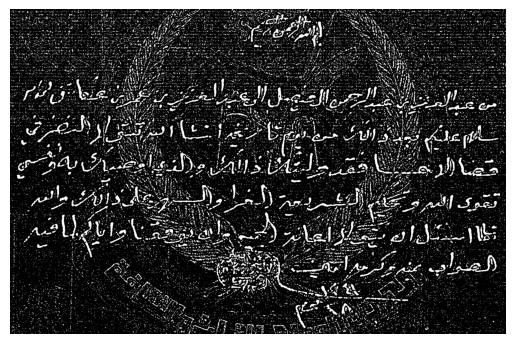

In [35]:
plt.imshow(bw, cmap="gray")
plt.axis("off")
plt.show()

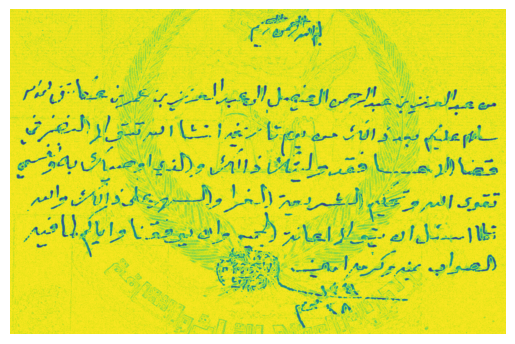

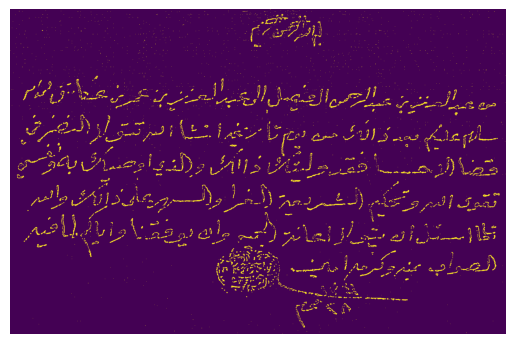

In [36]:
import cv2
import numpy as np

# Load the image
img = cv2.imread("H_W_Text_09.jpg")
#img = cv2.imread("scanned_doc.png")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Estimate background using a large blur
background = cv2.medianBlur(gray, 21)

# Subtract background and normalize
diff = 255 - cv2.absdiff(gray, background)
norm = cv2.normalize(diff, None, 0, 255, cv2.NORM_MINMAX)

#cv2.imwrite("bg_removed.png", norm)

plt.imshow(norm)
plt.axis('off')  # Hide axes
plt.show()
plt.imshow(thresh)
plt.axis('off')  # Hide axes
plt.show()

In [39]:
bw = cv2.bitwise_not(thresh)

In [43]:
bw = cv2.bitwise_not(bw)

In [ ]:
bw = cv2.adaptiveThreshold(
    norm, 255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY,
    15, 10
)

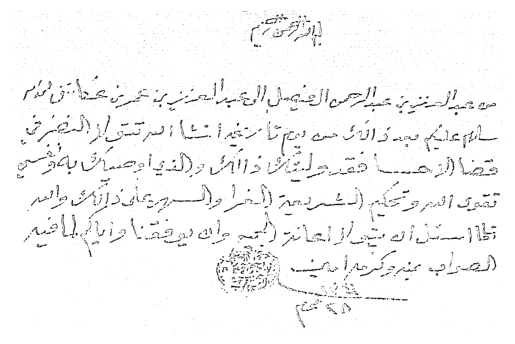

In [44]:
plt.imshow(bw,cmap="gray")
plt.axis('off')  # Hide axes
plt.show()

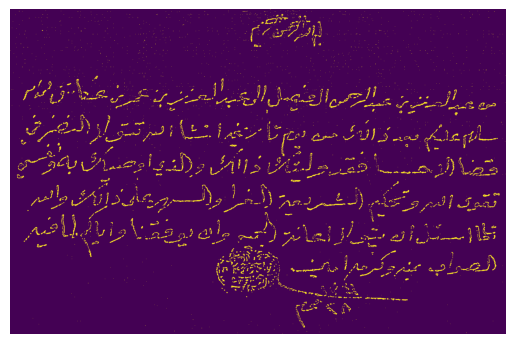

In [15]:
import cv2
import numpy as np

# Load the image
img = cv2.imread("H_W_Text_09.jpg")

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply adaptive thresholding
thresh = cv2.adaptiveThreshold(
    gray, 255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY,
    11, 15
)

# Invert if needed (white text on black)
thresh = cv2.bitwise_not(thresh)

plt.imshow(thresh)
plt.axis('off')  # Hide axes
plt.show()

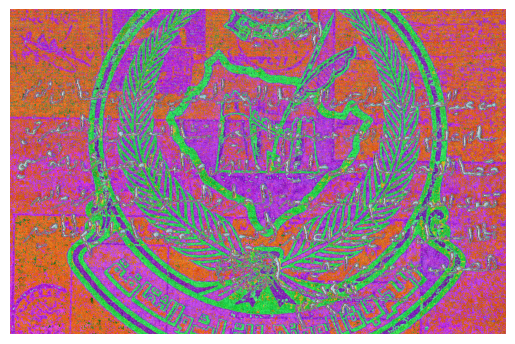

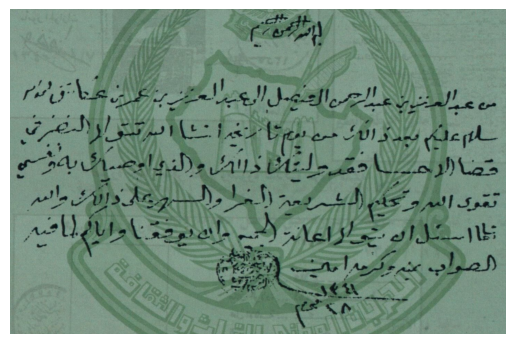

In [14]:
import cv2
import numpy as np

img = cv2.imread("H_W_Text_09.jpg")

alpha = 5
beta = 100

new = alpha * img + beta
new = np.clip(new, 0, 255).astype(np.uint8)
plt.imshow(new)
plt.axis('off')  # Hide axes
plt.show()

plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()
#cv2.imwrite("cleaned.png", new)

#Calculate Word Error Rate (WER)
📌 What is WER?

WER measures the difference between a predicted transcription and the ground truth.

WER
=(
𝑆
+
𝐷
+
𝐼)/
𝑁
	​


Where:

S = Substitutions

D = Deletions

I = Insertions

N = Number of words in reference (ground truth)

A lower WER means better OCR accuracy.

In [ ]:
!pip install jiwer


In [ ]:
from jiwer import wer

reference = "الأول: «محوِم مصاد إنسرائيل الجطلع"
hypothesis = "الأول «محوِم مصاد الجطلع"

error = wer(reference, hypothesis)
print("WER:", error)

WER: 0.4


📌 What is Character Error Rate (CER)

CER is similar to WER but works on characters instead of words:

CER = ( 𝑆 + 𝐷 + 𝐼)/ 𝑁​
	​


Where:

S = substitutions

D = deletions

I = insertions

N = number of characters in the reference

In [ ]:

from jiwer import cer  # directly use CER function

reference = "هذا هو النص الصحيح"
hypothesis = "هذا النص الصحيح"

error = cer(reference, hypothesis)
print("CER:", error)

# BLEU Score

BLEU evaluates how similar the predicted text is to a reference (commonly used for translation or OCR text evaluation). It works on words or n-grams.

# Measure WER, CER, and BLEU in a single evaluation function for Arabic OCR

In [ ]:
# Install required libraries if not already
!pip install jiwer nltk --quiet

from jiwer import wer, cer
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, SmoothingFunction

def evaluate_ocr(references, hypotheses):
    """
    Compute WER, CER, and BLEU scores for OCR predictions.

    Args:
        references (list or str): Ground truth text(s)
        hypotheses (list or str): Predicted OCR text(s)

    Returns:
        dict: {'WER': float, 'CER': float, 'BLEU': float}
    """

    # Ensure both inputs are lists
    if isinstance(references, str):
        references = [references]
    if isinstance(hypotheses, str):
        hypotheses = [hypotheses]

    assert len(references) == len(hypotheses), "Length of references and hypotheses must match."

    # WER
    avg_wer = sum(wer(r, h) for r, h in zip(references, hypotheses)) / len(references)

    # CER
    avg_cer = sum(cer(r, h) for r, h in zip(references, hypotheses)) / len(references)

    # BLEU (word-level)
    references_split = [[r.split()] for r in references]
    hypotheses_split = [h.split() for h in hypotheses]
    avg_bleu = corpus_bleu(references_split, hypotheses_split, smoothing_function=SmoothingFunction().method1)

    return {
        'WER': avg_wer,
        'CER': avg_cer,
        'BLEU': avg_bleu
    }

# Example usage
references = ["هذا هو النص الصحيح", "مرحبا بالعالم"]
hypotheses = ["هذا النص الصحيح", "مرحبا بالعالم!"]

metrics = evaluate_ocr(references, hypotheses)
print(metrics)
